In [1]:
import os
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/goodreads-books-reviews-290312/goodreads_test.csv
/kaggle/input/goodreads-books-reviews-290312/goodreads_sample_submission.csv
/kaggle/input/goodreads-books-reviews-290312/goodreads_train.csv


In [2]:
!pip install --quiet keras-tcn

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-io 0.21.0 requires tensorflow-io-gcs-filesystem==0.21.0, which is not installed.
dask-cudf 21.10.1 requires cupy-cuda114, which is not installed.
beatrix-jupyterlab 3.1.7 requires google-cloud-bigquery-storage, which is not installed.
xarray-einstats 0.2.2 requires numpy>=1.21, but you have numpy 1.19.5 which is incompatible.
tfx-bsl 1.9.0 requires tensorflow!=2.0.*,!=2.1.*,!=2.2.*,!=2.3.*,!=2.4.*,!=2.5.*,!=2.6.*,!=2.7.*,!=2.8.*,<3,>=1.15.5, but you have tensorflow 2.6.4 which is incompatible.
tensorflow-transform 1.9.0 requires tensorflow!=2.0.*,!=2.1.*,!=2.2.*,!=2.3.*,!=2.4.*,!=2.5.*,!=2.6.*,!=2.7.*,!=2.8.*,<2.10,>=1.15.5, but you have tensorflow 2.6.4 which is incompatible.
tensorflow-serving-api 2.9.0 requires tensorflow<3,>=2.9.0, but you have tensorflow 2.6.4 which is incompatible.
pytorch-lightni

In [3]:
from tcn import TCN, tcn_full_summary

NUM_WORDS = 5000
EMBEDDING_DIM = 300
MAXLEN = 500
PADDING = 'post'
OOV_TOKEN = "<OOV>"
TRAINING_SPLIT = .8

# Functions:

In [4]:
def remove_stop_words(dataframe):
    stopwords = ["a", "about", "above", "after", "again", "against", "all", "am", "an", "and", "any", "are", "as",
                 "at", "be", "because", "been", "before", "being", "below", "between", "both", "but", "by", "could", 
                 "did", "do", "does", "doing", "down", "during", "each", "few", "for", "from", "further", "had", "has",
                 "have", "having", "he", "he'd", "he'll", "he's", "her", "here", "here's", "hers", "herself", "him", "himself",
                 "his", "how", "how's", "i", "i'd", "i'll", "i'm", "i've", "if", "in", "into", "is", "it", "it's", "its", "itself",
                 "let's", "me", "more", "most", "my", "myself", "nor", "of", "on", "once", "only", "or", "other", "ought", "our", "ours",
                 "ourselves", "out", "over", "own", "same", "she", "she'd", "she'll", "she's", "should", "so", "some", "such", "than", "that",
                 "that's", "the", "their", "theirs", "them", "themselves", "then", "there", "there's", "these", "they", "they'd", "they'll", "they're", 
                 "they've", "this", "those", "through", "to", "too", "under", "until", "up", "very", "was", "we", "we'd", "we'll", "we're",
                 "we've", "were", "what", "what's", "when", "when's", "where", "where's", "which", "while", "who", "who's", "whom", "why", 
                 "why's", "with", "would", "you", "you'd", "you'll", "you're", "you've", "your", "yours", "yourself", "yourselves" ]
    clean_reviews = []
    for i in range(len(dataframe)):
        review = dataframe.review_text.iloc[i]
        review = review.lower()
        clean_review = " ".join([word for word in review.split(" ") if word not in stopwords])
        
        clean_reviews.append(clean_review)
    return clean_reviews

In [5]:
def fit_tokenizer(review_list, num_words, oov_token):
    
    tokenizer = Tokenizer(num_words=num_words, oov_token = oov_token)
    tokenizer.fit_on_texts(review_list)
    return tokenizer

def _get_padded_sequences(tokenizer, reviews, padding, maxlen):
    
    sequences = tokenizer.texts_to_sequences(reviews)
    padded_sequences = pad_sequences(sequences, padding=padding, maxlen=maxlen)
    
    return padded_sequences

In [6]:
def plot_graphs(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history[f'val_{metric}'])
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, f'val_{metric}'])
    plt.show()

# Read and process data:

In [7]:
train_full_data = pd.read_csv("/kaggle/input/goodreads-books-reviews-290312/goodreads_train.csv")

In [8]:
%%time
scaler = StandardScaler()
train_full_data["n_votes_norm"] = scaler.fit_transform(train_full_data.n_votes.to_numpy().reshape(-1, 1))
train_full_data["n_comments_norm"] =scaler.fit_transform(train_full_data.n_comments.to_numpy().reshape(-1, 1))
train_data, val_data = train_test_split(train_full_data, test_size=0.2, random_state=42)
train_labels = train_data.rating
train_sentences = remove_stop_words(train_data)
train_numerical = train_data[["n_votes_norm", "n_comments_norm"]].to_numpy()

val_labels = val_data.rating
val_sentences = remove_stop_words(val_data)
val_numerical = val_data[["n_votes_norm", "n_comments_norm"]].to_numpy()

print(f"There are {len(train_sentences)} reviews for training.\n")
print(f"There are {len(train_labels)} labels for training.\n")
print(f"There are {len(train_numerical)} numerical features for training.\n")
print(f"There are {len(val_sentences)} reviews for validation.\n")
print(f"There are {len(val_labels)} labels for validation.\n")
print(f"There are {len(val_numerical)} numerical features for validation.")


There are 720000 reviews for training.

There are 720000 labels for training.

There are 720000 numerical features for training.

There are 180000 reviews for validation.

There are 180000 labels for validation.

There are 180000 numerical features for validation.
CPU times: user 5min 32s, sys: 1.2 s, total: 5min 33s
Wall time: 5min 36s


In [9]:
%%time
tokenizer = fit_tokenizer(train_sentences, num_words=NUM_WORDS, oov_token=OOV_TOKEN)
word_index = tokenizer.word_index

print(f"Vocabulary contains {len(word_index)} words\n")
print("<OOV> token included in vocabulary" if "<OOV>" in word_index else "<OOV> token NOT included in vocabulary")

train_padded_seq = _get_padded_sequences(tokenizer, train_sentences, PADDING, MAXLEN)
val_padded_seq = _get_padded_sequences(tokenizer, val_sentences, PADDING, MAXLEN)

print(f"Padded training reviews have shape: {train_padded_seq.shape}\n")
print(f"Padded validation reviews have shape: {val_padded_seq.shape}")

Vocabulary contains 317717 words

<OOV> token included in vocabulary
Padded training reviews have shape: (720000, 500)

Padded validation reviews have shape: (180000, 500)
CPU times: user 2min 1s, sys: 1.17 s, total: 2min 2s
Wall time: 2min 3s


# Prepare embedding layer:

In [10]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip -q glove.6B.zip

--2022-08-05 08:02:10--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2022-08-05 08:02:10--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2022-08-05 08:02:11--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

In [11]:
%%time
embeddings_index = {}
with open("./glove.6B.300d.txt") as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs

print("Found %s word vectors." % len(embeddings_index))

hits = 0
misses = 0

# Prepare embedding matrix
embedding_matrix = np.zeros((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in embedding index will be all-zeros.
        # This includes the representation for "padding" and "OOV"
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1
print("Converted %d words (%d misses)" % (hits, misses))

Found 400000 word vectors.
Converted 110327 words (207390 misses)
CPU times: user 16.1 s, sys: 804 ms, total: 16.9 s
Wall time: 17.3 s


# Model:

In [17]:
def tcn_model(inputs, embedding_dim, word_index, embedd_matrix,):
    
    x = tf.keras.layers.Embedding(input_dim=len(word_index) + 1,
                                  output_dim=embedding_dim,
                                  weights=[embedd_matrix],
                                  input_length=MAXLEN,
                                  trainable=False)(inputs)
    
    x = tf.keras.layers.SpatialDropout1D(0.1)(x)
    x = TCN(128,dilations = [1, 2, 4], return_sequences=True, activation = "relu", name = 'tcn1')(x)
    x = TCN(128,dilations = [1, 2, 4], return_sequences=True, activation = "relu", name = 'tcn2')(x)
    
    avg_pool = tf.keras.layers.GlobalAveragePooling1D()(x)
    max_pool = tf.keras.layers.GlobalMaxPooling1D()(x)
    
    concat = tf.keras.layers.concatenate([avg_pool, max_pool])
    
    dense1 = tf.keras.layers.Dense(256, activation="relu")(concat)
    dropout1 = tf.keras.layers.Dropout(0.3)(dense1)
    dense2 = tf.keras.layers.Dense(128, activation="relu")(dropout1)
    dropout2 = tf.keras.layers.Dropout(0.3)(dense2)
    dense3 = tf.keras.layers.Dense(64, activation="relu")(dropout2)
    dropout3 = tf.keras.layers.Dropout(0.3)(dense3)

    return dropout3

def num_head(inputs):
    
    dense1 = tf.keras.layers.Dense(32, activation="relu")(inputs)
    dense2 = tf.keras.layers.Dense(16, activation="relu")(dense1)
    return dense2

def final_model():
    text_input = tf.keras.layers.Input(shape=(MAXLEN,))
    tcn = tcn_model(text_input, EMBEDDING_DIM, word_index, embedding_matrix)

    numerical_input = tf.keras.layers.Input(shape=(2,))
    num_feat_extract = num_head(numerical_input)
    
    concat = tf.keras.layers.concatenate([tcn, num_feat_extract])
    dense = tf.keras.layers.Dense(128, activation="relu")(concat)
    dropout = tf.keras.layers.Dropout(0.4)(dense)
    final_dense = tf.keras.layers.Dense(6, activation="softmax")(dropout)
    
    model = tf.keras.Model([text_input, numerical_input], outputs=[final_dense])

    return model

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 500)]        0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 500, 300)     95315400    input_4[0][0]                    
__________________________________________________________________________________________________
spatial_dropout1d_2 (SpatialDro (None, 500, 300)     0           embedding_2[0][0]                
__________________________________________________________________________________________________
tcn1 (TCN)                      (None, 500, 128)     400256      spatial_dropout1d_2[0][0]        
____________________________________________________________________________________________

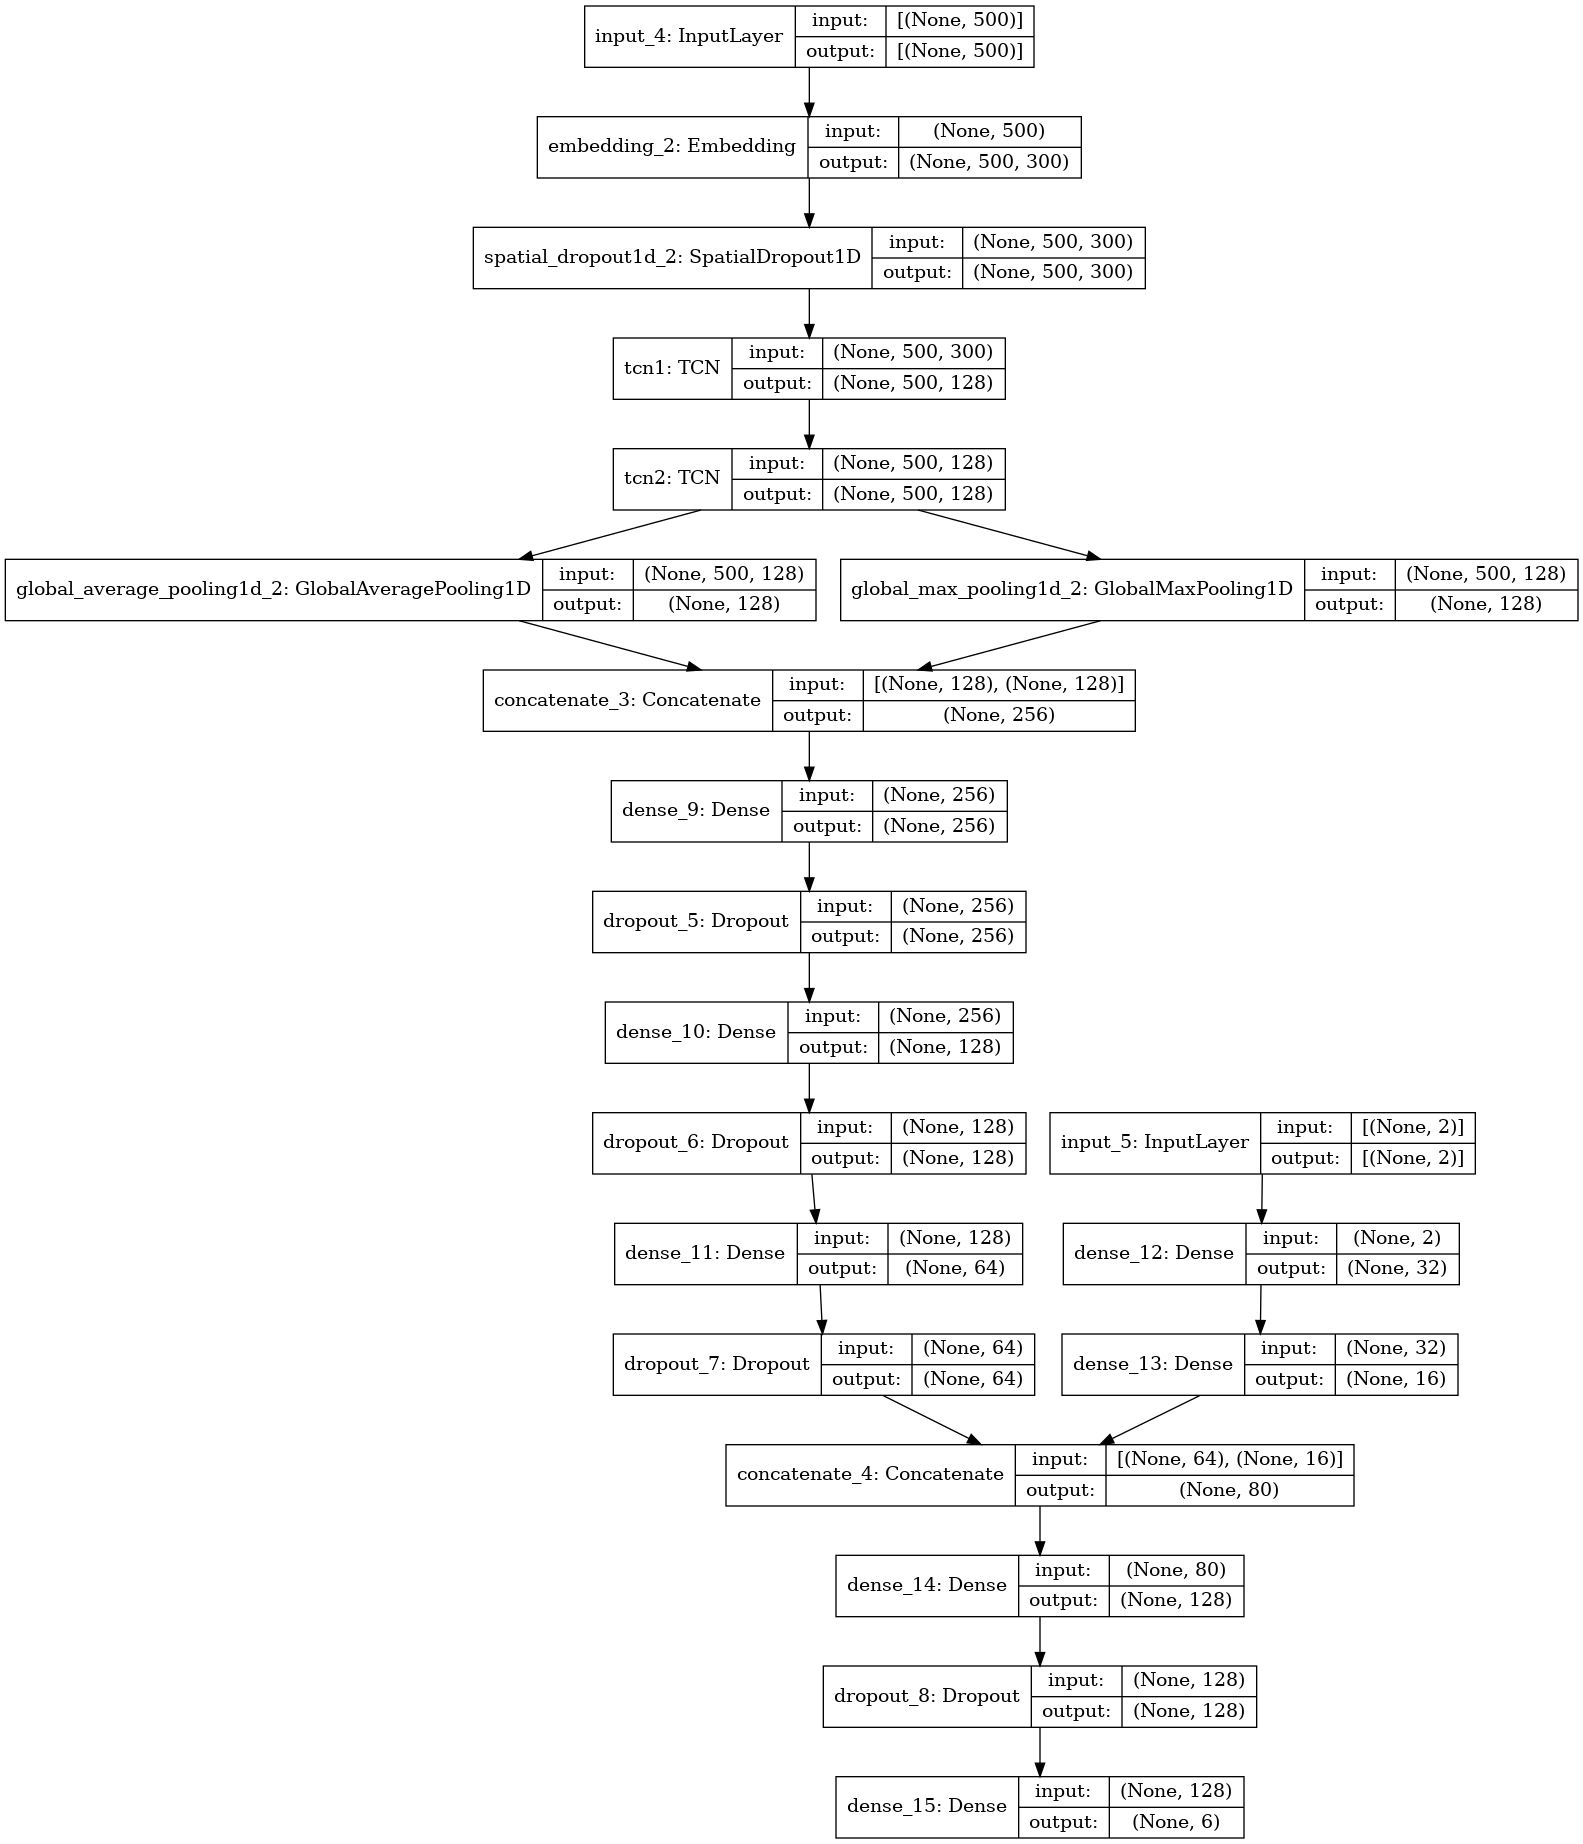

In [18]:
model = final_model()
model.compile(loss="sparse_categorical_crossentropy",
              optimizer="adam",
              metrics=['accuracy']) 
print(model.summary())
tf.keras.utils.plot_model(model, show_shapes=True, show_layer_names=True)

In [19]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor="val_loss", mode="min", restore_best_weights=True, patience=5)
history = model.fit(x=[train_padded_seq, train_numerical], 
                    y=train_labels, 
                    epochs=15,
                    batch_size=128,
                    validation_data=([val_padded_seq, val_numerical], val_labels),
                    callbacks=[early_stop]
                   )

Epoch 1/15
5625/5625 [==============================] - 570s 101ms/step - loss: 1.1356 - accuracy: 0.5138 - val_loss: 1.0432 - val_accuracy: 0.5626
Epoch 2/15
5625/5625 [==============================] - 567s 101ms/step - loss: 1.0308 - accuracy: 0.5613 - val_loss: 0.9947 - val_accuracy: 0.5752
Epoch 3/15
5625/5625 [==============================] - 567s 101ms/step - loss: 1.0072 - accuracy: 0.5716 - val_loss: 0.9819 - val_accuracy: 0.5795
Epoch 4/15
5625/5625 [==============================] - 569s 101ms/step - loss: 0.9964 - accuracy: 0.5766 - val_loss: 0.9733 - val_accuracy: 0.5839
Epoch 5/15
5625/5625 [==============================] - 567s 101ms/step - loss: 0.9908 - accuracy: 0.5800 - val_loss: 0.9786 - val_accuracy: 0.5808
Epoch 6/15
5625/5625 [==============================] - 566s 101ms/step - loss: 0.9865 - accuracy: 0.5811 - val_loss: 0.9807 - val_accuracy: 0.5821
Epoch 7/15
4769/5625 [========================>.....] - ETA: 1:18 - loss: 0.9845 - accuracy: 0.5831

KeyboardInterrupt: 